In this project we will compare the performance of LDA and SVM for face recognition. Will use the Olivetti faces dataset, which contains 400 64x64 images from 40 different subjects, and your task is to discover the identity of a given face image. Some of these images are illustrated below.

<img src="m6project.png" width="400"/>

We will solve the task above using:
- LDA
- SVM

For LDA:
- Visualize a 2D representation of the faces in the dataset

Will try to split the dataset so that the first 5 images per subject are used for training, and the last 5 images are used for testing. Will use part of your training data as validation set and ompare the performance of LDA and SVM in terms of:
- Average F-Score
- Confusion matrix
- Visualize the individuals with highest confusion and check if they look alike

# Implementation


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os

In [ ]:
# Get the dataset

faces = fetch_olivetti_faces()
_, img_height, img_width = faces.images.shape
print(faces.images.shape)

(400, 64, 64)


In [ ]:
# Split the dataset

N_IDENTITIES = len(np.unique(faces.target)) # how many different individuals are in the dataset
GALLERY_SIZE = 5                            # use the first GALLERY_SIZE images per individual for training, the rest for testing

gallery_indices = []
probe_indices = []
for i in range(N_IDENTITIES):
    indices = list(np.where(faces.target == i)[0])
    gallery_indices += indices[:GALLERY_SIZE]
    probe_indices += indices[GALLERY_SIZE:]

x_train = faces.images[gallery_indices].reshape(-1, img_height*img_width) # vectorize train images
y_train = faces.target[gallery_indices]
x_test = faces.images[probe_indices].reshape(-1, img_height*img_width)    # vectorize test images
y_test = faces.target[probe_indices]

print(x_train.shape, x_test.shape)

(200, 4096) (200, 4096)


TRAINING


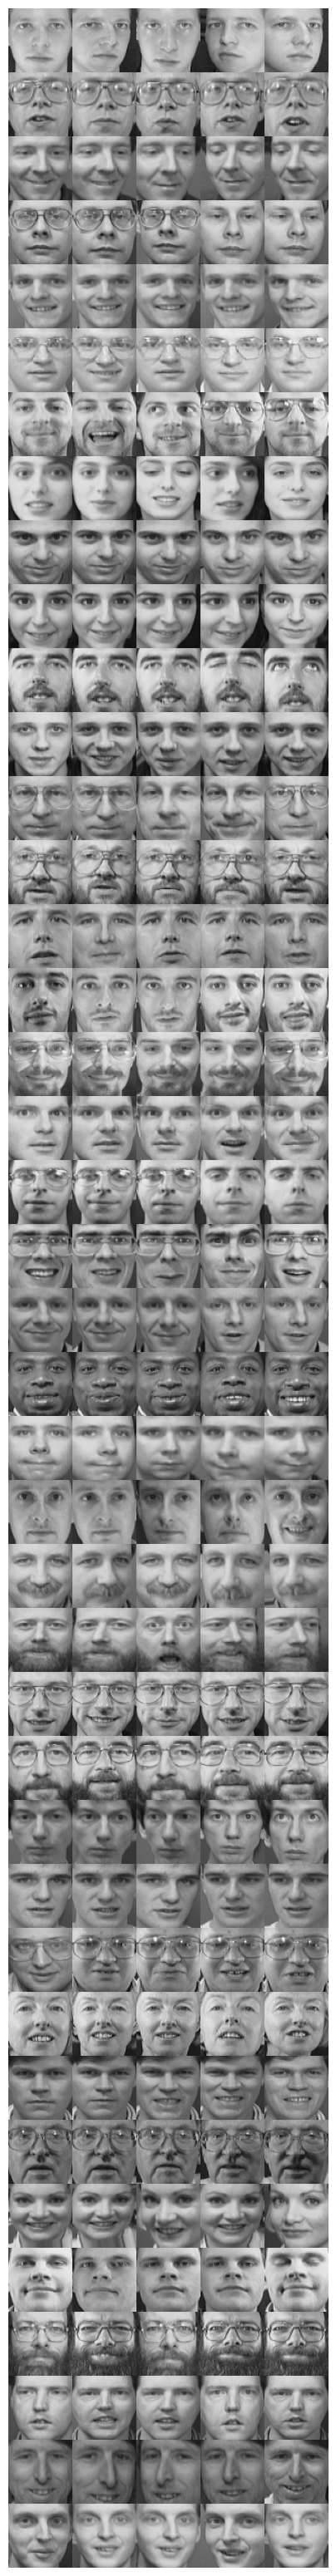

TESTING


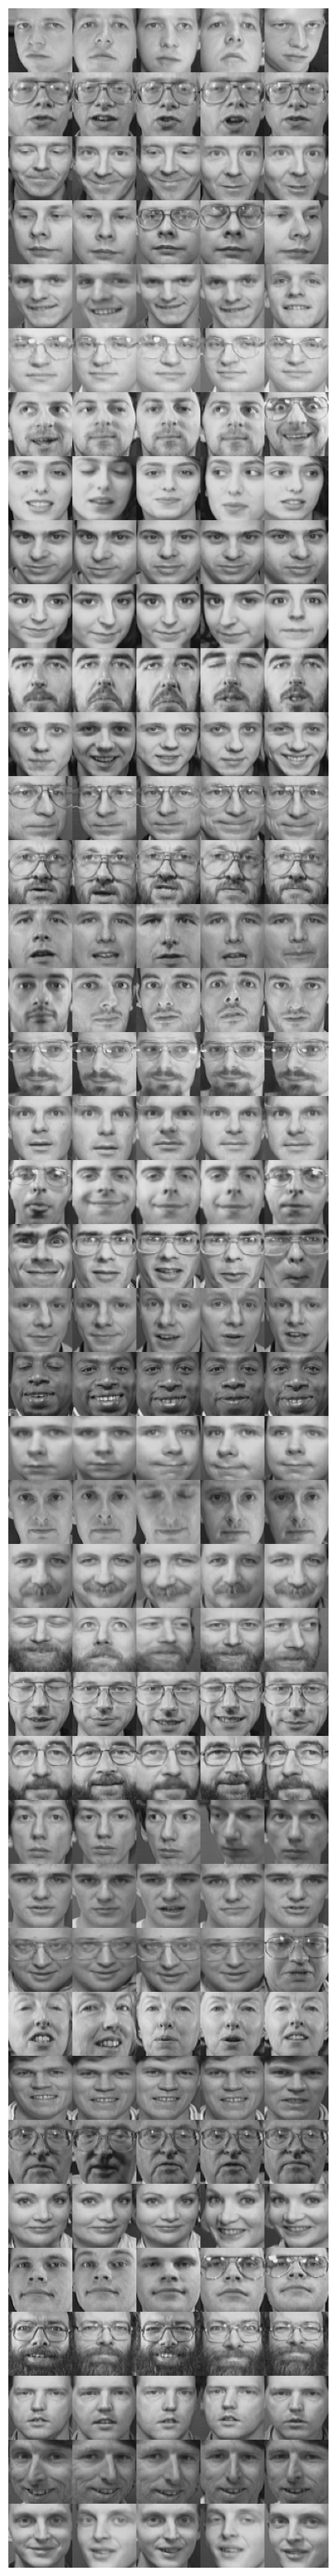

In [ ]:
# Visualize image sets
def show_images(imgs, num_rows, num_cols):
    assert len(imgs) == num_rows*num_cols

    full = None
    for i in range(num_rows):
        row = None
        for j in range(num_cols):
            if row is None:
                row = imgs[i*num_cols+j].reshape(img_height, img_width)*255.0
            else:
                row = np.concatenate((row, imgs[i*num_cols+j].reshape(img_height, img_width)*255.0), axis=1)
        if full is None:
            full = row
        else:
            full = np.concatenate((full, row), axis=0)

    f = plt.figure(figsize=(num_cols, num_rows))
    plt.imshow(full, cmap='gray')
    plt.axis('off')
    plt.show()

print('TRAINING')
show_images(x_train, N_IDENTITIES, GALLERY_SIZE)
print('TESTING')
show_images(x_test, N_IDENTITIES, 10 - GALLERY_SIZE)

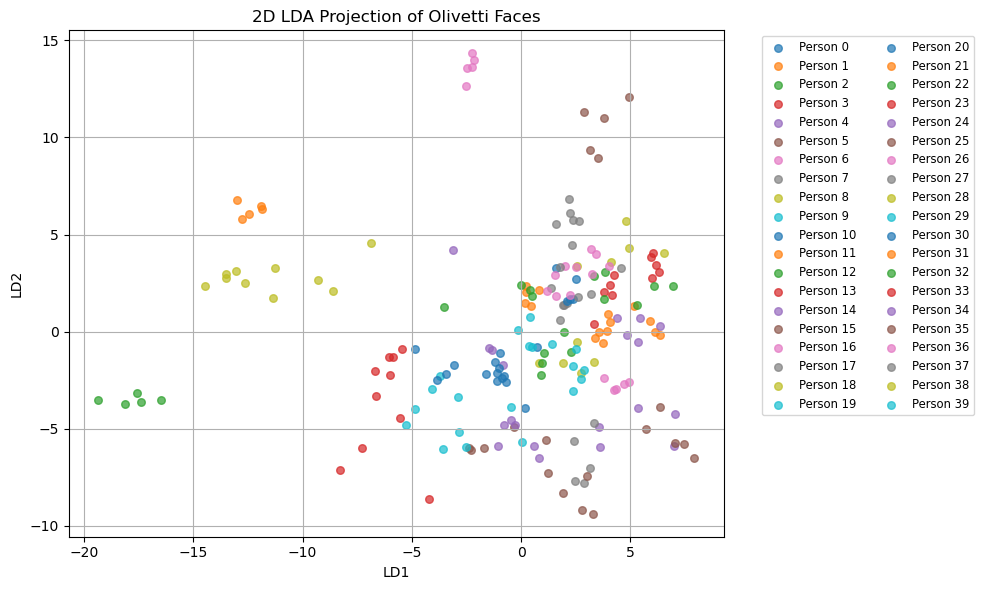

In [ ]:
# LDA
lda = LDA()
lda.fit(x_train, y_train)
y_pred_lda = lda.predict(x_test)
fscore_lda = f1_score(y_test, y_pred_lda, average='macro')
cm_lda = confusion_matrix(y_test, y_pred_lda)

# SVM
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
y_pred_svm = svm.predict(x_test)
fscore_svm = f1_score(y_test, y_pred_svm, average='macro')
cm_svm = confusion_matrix(y_test, y_pred_svm)

# 2D Visualization using LDA
lda_2d = LDA(n_components=2)
x_lda_2d = lda_2d.fit_transform(x_train, y_train)

plt.figure(figsize=(10, 6))
for class_id in np.unique(y_train):
    plt.scatter(
        x_lda_2d[y_train == class_id, 0],
        x_lda_2d[y_train == class_id, 1],
        label=f"Person {class_id}", alpha=0.7, s=30
    )

plt.title("2D LDA Projection of Olivetti Faces")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.grid(True)
plt.show()

Average F1-Score (LDA): 0.8968
Average F1-Score (SVM): 0.9006


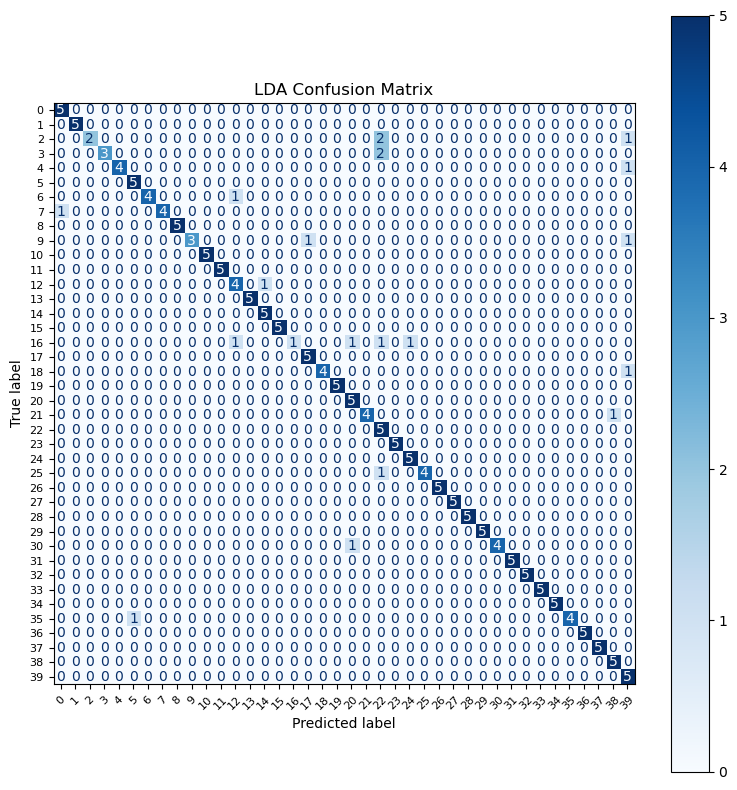

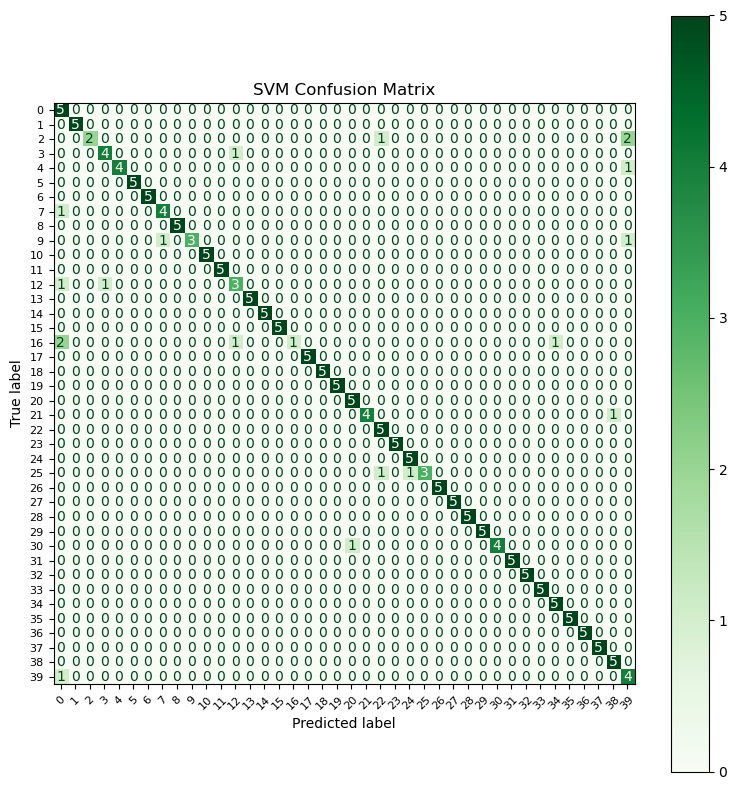

In [ ]:
# Average F-scores of LDA and SVM
print(f"Average F1-Score (LDA): {fscore_lda:.4f}")
print(f"Average F1-Score (SVM): {fscore_svm:.4f}")

# Confusion matrix for LDA
fig, ax = plt.subplots(figsize=(8, 8))  # Setting figure size here
cm_lda = confusion_matrix(y_test, y_pred_lda)
disp_lda = ConfusionMatrixDisplay(cm_lda)
disp_lda.plot(cmap='Blues', values_format='d', ax=ax)
plt.title("LDA Confusion Matrix")
plt.xticks(fontsize=8, rotation=45)   # 45 degree rotation on x-axis
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

# Confusion matrix for SVM
fig, ax = plt.subplots(figsize=(8, 8))   # Setting figure size here
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(cm_svm)
disp_svm.plot(cmap='Greens', values_format='d', ax=ax)
plt.title("SVM Confusion Matrix")
plt.xticks(fontsize=8, rotation=45)   # 45 degree rotation on x-axis
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


 f2 Most confused pair: Person 2 <-> Person 22 | Count: 2


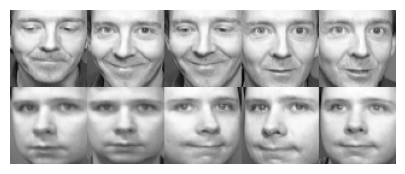


 f2 Most confused pair: Person 3 <-> Person 22 | Count: 2


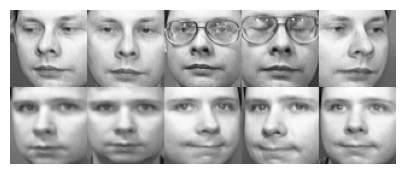

In [ ]:
# To find the most confused pair in LDA confusion matrix
cm_copy = cm_lda.copy()
np.fill_diagonal(cm_copy, 0)  # ignore correct predictions

# Number of top confused pairs to display
N = 2  # can pass N = 1 to identify the top most confused pair that will be Person 2 <-> Person 22

# Get the top-N most confused pairs (flattened indices)
flat = cm_copy.flatten()
top_n_indices = flat.argsort()[-N:][::-1]

for idx in top_n_indices:
    i, j = divmod(idx, cm_copy.shape[1])
    print(f"\n f{N} Most confused pair: Person {i} <-> Person {j} | Count: {cm_copy[i, j]}")

    # Collect test images for Person i and j
    imgs = []
    for person in [i, j]:
        indices = np.where(y_test == person)[0]
        imgs.extend(x_test[indices[:5]])  # take first 5 test images

    # Visualize the 2x5 grid
    show_images(imgs, 2, 5)

# Report template

### Visualization of the 2D face representation computed by LDA
We tried to reduced the high-dimensional facial data (4096 dimensions per image) into two discriminative components in LDA, maximizing class separability.
The 2D scatter plot below shows each identity as a distinct color cluster. While some identities are tightly grouped, others overlap due to visual similarity or expression variation.

![image.png](attachment:da4bd66b-d660-4193-a3c3-92d172f353bd.png)

### Experimental results

##### Training description
Dataset:
Olivetti Faces (400 grayscale images, 40 individuals × 10 images each)

Split:
- First 5 images per person -> Training Set
- Last 5 images per person -> Test Set

Models Used:
- LDA (Linear Discriminant Analysis)
- SVM (Support Vector Machine) with linear kernel

Metrics:
- Average F1-score (Macro)
- Confusion Matrix
- Most confused pairs visualization

##### Obtained results

| Model |&#124;| Average F1-Score | |
|-------------|------|-------|------|
| LDA         |&#124;| 0.8968     |
| SVM         |&#124;| 0.9006     |

- LDA Confusion Matrix: Some identities had high confusion (e.g., Person 2 and 22).
![image.png](attachment:3daea25b-b6c4-4938-afce-f7e25f39f404.png)

- SVM Confusion Matrix: Better separation, fewer overlaps.
![image.png](attachment:7601db3d-4b9b-49c4-b1a7-397341ee803a.png)

##### Analysis results

- SVM outperformed LDA slightly in terms of F1-score due to its ability to find linear boundaries in higher dimensions.
- LDA still produced competitive results, and its transformation allowed for interpretable 2D visualizations.
- Confusion in both models typically occurred between individuals with similar facial structures, expressions, or lighting.

##### Visualization of the individuals with highest confusion

The top 2  most confused pairs off the individuals are :

![image.png](attachment:fe116c68-7b17-43c8-87b5-da37d8ee9c94.png)

- The first most confused pair ( 2 <-> 22 ) share facial features and expressions, which likely contributed to the classifier's confusion. But, when seen with human naked eyes, we can observe that the facial shape is completely different for both the persons in images and clearly able to differentiate that they are two different people.
- But in the case of second pair, though there are couple of images with spects for one person, the facial shape, structure, expressions, features everything almost looks similar even to human naked eyes. So, this pair might actually be confusing as per my opinion..